In [59]:
from dotenv import load_dotenv
import os

from langchain_openai import ChatOpenAI

from langchain_core.messages import AnyMessage, AIMessage, HumanMessage, SystemMessage

from typing_extensions import TypedDict, Annotated
import operator

from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.prebuilt import ToolNode, tools_condition

from IPython.display import Image, display

from langchain_community.tools import WikipediaQueryRun, DuckDuckGoSearchRun, YouTubeSearchTool
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

from langchain.tools import tool

import yfinance as yf

_ = load_dotenv()

In [2]:
chat_llm = ChatOpenAI(
    base_url='https://api.deepseek.com',
    model='deepseek-reasoner',
    api_key=os.getenv('DEEPSEEK_API')
)

chat_llm.invoke('Hello, how are you ?').content

"Hello! I'm just a computer program, so I don't have feelings, but I'm functioning perfectly and ready to help you. 😊\n\nHow are *you* doing today? Is there anything I can assist you with?"

In [3]:
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [4]:
def llm_call(state: GraphState) -> dict:
    response = chat_llm.invoke(state['messages'])
    return {'messages': [response]}

In [5]:
def token_counter(state: GraphState) -> dict:
    last_msg = state['messages'][-1]
    text = last_msg.content
    token_number = len(text.split())
    summary = f'Total token number in the generated answer (word count) is {token_number}'
    return {'messages': [AIMessage(content=summary)]}

In [6]:
builder = StateGraph(GraphState)

In [7]:
builder.add_node('llm_call', llm_call)
builder.add_node('token_counter', token_counter)

In [8]:
builder.set_entry_point('llm_call')
builder.add_edge('llm_call', 'token_counter')
builder.set_finish_point('token_counter')

In [9]:
app = builder.compile()

In [10]:
app.get_graph()

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnableCallable(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'llm_call': Node(id='llm_call', name='llm_call', data=llm_call(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'token_counter': Node(id='token_counter', name='token_counter', data=token_counter(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=None, metadata=None)}, edges=[Edge(source='__start__', target='llm_call', data=None, conditional=False), Edge(source='llm_call', target='token_counter', data=None, conditional=False), Edge(source='token_counter', target='__end__', data=None, conditional=False)])

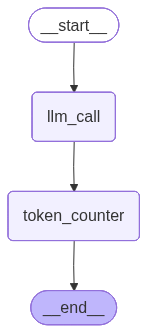

In [11]:
display(Image(app.get_graph().draw_mermaid_png()))

In [12]:
result = app.invoke(
    {
        'messages': [HumanMessage(content='Hi, this is Bob. Say hello in detail.')]
    }
)

In [13]:
result

{'messages': [HumanMessage(content='Hi, this is Bob. Say hello in detail.', additional_kwargs={}, response_metadata={}),
  AIMessage(content="Hello, Bob! It's a genuine pleasure to meet you. I hope this message finds you having a truly wonderful day, wherever you are and whatever you're doing.\n\nA detailed hello means more than just the word—it's an acknowledgment, a small moment of connection. So, welcome. I'm here, ready to listen, chat, help with questions, brainstorm ideas, or just offer a bit of digital companionship. Whether you're here for something specific or just passing the time, I'm glad our paths crossed.\n\nWhat's on your mind today, Bob? I'm all ears.\n\nWarmly,\nYour AI Assistant", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 247, 'prompt_tokens': 15, 'total_tokens': 262, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 120, 'rejected_prediction_tokens': None}, 'p

In [14]:
for m in result['messages']:
    print(f"{type(m).__name__}: {m.content}")

HumanMessage: Hi, this is Bob. Say hello in detail.
AIMessage: Hello, Bob! It's a genuine pleasure to meet you. I hope this message finds you having a truly wonderful day, wherever you are and whatever you're doing.

A detailed hello means more than just the word—it's an acknowledgment, a small moment of connection. So, welcome. I'm here, ready to listen, chat, help with questions, brainstorm ideas, or just offer a bit of digital companionship. Whether you're here for something specific or just passing the time, I'm glad our paths crossed.

What's on your mind today, Bob? I'm all ears.

Warmly,
Your AI Assistant
AIMessage: Total token number in the generated answer (word count) is 93


In [16]:
api_wrapper = WikipediaAPIWrapper(top_k_results=5, doc_content_chars_max=500)

In [17]:
wiki_tool = WikipediaQueryRun(api_wrapper=api_wrapper)

In [18]:
wiki_tool.run({'query': 'Quantitative finance'})

'Page: Quantitative analysis (finance)\nSummary: Quantitative analysis in finance refers to the application of mathematical and statistical methods to problems in financial markets and investment management. Professionals in this field are known as quantitative analysts or quants.  \nQuants typically specialize in areas such as derivative structuring and pricing, risk management, portfolio management, and other finance-related activities. The role is analogous to that of specialists in industrial m'

In [23]:
tool = TavilySearchResults(tavily_api_key=os.getenv('TAVILY_API'))

In [24]:
tool.invoke({'query': 'When is the next soccer world cup?'})

[{'title': '2026 World Cup Schedule – USA, Canada and Mexico - Roadtrips',
  'url': 'https://www.roadtrips.com/world-cup/2026-world-cup-packages/schedule/',
  'content': '## When is the Next World Cup?\n\nThe next World Cup will take place from Thursday, June 11 to Sunday, July 19, 2026. The tournament will be hosted across the United States, Canada, and Mexico, featuring 48 teams and 104 matches over 39 days. Below are some key details about the 2026 World Cup schedule.\n\n + The 2026 World Cup will be the first to take place with 48 teams, expanded from 32 in 2022.\n  + For the group stage, teams will be divided into twelve groups of four teams.\n  + The top two teams from each group plus the eight best third place teams will proceed to the (new) Round of 32.\n  + All matches after the group stage will be knockout format.\n  + A total of 104 matches will be played, up from 64 at the 2022 edition. [...] 1-800-465-1765  Get Custom Quote\n\n# 2026 World Cup Schedule\n\nWorld Cup Menu\n\

In [26]:
search = DuckDuckGoSearchRun()

search.invoke({'query': 'When is the next soccer world cup?'})

Impersonate 'safari_17.5' does not exist, using 'random'


"1 day ago - The 2026 FIFA World Cup, marketed as FIFA World Cup 26, will be the 23rd FIFA World Cup, the quadrennial international men's soccer championship contested by the national teams of the member associations of FIFA. The tournament will take place from June 11 to July 19, 2026 . 6 days ago - United 2026 , also known as the North American 2026 bid, was a successful joint bid led by the United States Soccer Federation, together with the Canadian Soccer Association and the Mexican Football Federation, to host the 2026 FIFA World Cup ... 3 weeks ago - We’ve detailed the complete 2026 World Cup schedule below to assist you with your planning for this thrilling tournament. The next World Cup will take place from Thursday, June 11 to Sunday, July 19, 2026 . 19 hours ago - The full schedule with dates, times and stadiums have been confirmed for all 104 games at the 2026 World Cup. 3 days ago - The news is really starting to ramp up ahead of the summer and you can follow it all right h

In [31]:
tool = YouTubeSearchTool()

In [32]:
tool.name

'youtube_search'

In [33]:
tool.description

'search for youtube videos associated with a person. the input to this tool should be a comma separated list, the first part contains a person name and the second a number that is the maximum number of video results to return aka num_results. the second part is optional'

In [34]:
tool.run('algo trading')

"['https://www.youtube.com/watch?v=1GSKa5_xKVQ&pp=ygUMYWxnbyB0cmFkaW5n', 'https://www.youtube.com/watch?v=9Y3yaoi9rUQ&pp=ygUMYWxnbyB0cmFkaW5n']"

In [ ]:
def multiply(a:int, b:int) -> int:
    return a * b

In [37]:
multiply(3, 5)

15

In [40]:
@tool
def multiply(a:int, b:int) -> int:
    '''Multiplies two integers and returns the result
    
        Args:
        a: int, a number
        b: int, a number
    '''
    return a * b

In [41]:
multiply.invoke({'a': 2, 'b': 4})

8

In [42]:
multiply.name

'multiply'

In [43]:
multiply.description

'Multiplies two integers and returns the result\n\n        Args:\n        a: int, a number\n        b: int, a number'

In [44]:
multiply.args

{'a': {'title': 'A', 'type': 'integer'},
 'b': {'title': 'B', 'type': 'integer'}}

In [47]:
@tool
def get_stock_price(ticker:str) -> str:
    '''Returns prices for a specified stock ticker

        Args:
        ticker:str, stock ticker
    '''
    try:
        stock = yf.Ticker(ticker)
        data = stock.history(period='1d')
        if data.empty:
            return f"There is no data for {ticker} ticker. Please, check it."
        latest_close = data['Close'].iloc[-1]
        currency = stock.info.get('currency', '')
        symbol_map = {
            'INR': '₹',
            'EUR': '€',
            'GBP': '£',
            'USD': '$'
        }
        symbol = symbol_map.get(currency, '')
        currency_text = currency if currency else ''
        if symbol:
            return f"The latest closing price of {ticker.upper()} was {symbol}{latest_close:.2f}"
        else:
            return f"The latest closing price of {ticker.upper()} was {latest_close:.2f} {currency_text}"
    except Exception as e:
        return f"The following error occured while fetching the data:\n{str(e)}"

In [49]:
get_stock_price.invoke('TCS.NS')

'The latest closing price of TCS.NS was ₹2717.40'

In [50]:
@tool
def get_word_length(word:str) -> int:
    '''Returns the length of a specified word

        Args:
        word: str, a word
    '''
    return len(word)

In [51]:
get_word_length.invoke('hello')

5

In [52]:
tools = [multiply, get_word_length, get_stock_price]

In [53]:
llm_with_tool = chat_llm.bind_tools(tools)

In [55]:
result = llm_with_tool.invoke('What is the stock price of TCS.NS?')
result

AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 467, 'total_tokens': 557, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 40, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 448}, 'prompt_cache_hit_tokens': 448, 'prompt_cache_miss_tokens': 19}, 'model_provider': 'openai', 'model_name': 'deepseek-reasoner', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': 'fc8b8283-6709-471c-9fbc-319b8d764325', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c6bba-4928-72f2-b388-af41274ea309-0', tool_calls=[{'name': 'get_stock_price', 'args': {'ticker': 'TCS.NS'}, 'id': 'call_00_5dfoq8C1Ikhslq0mgqxzcOsd', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 467, 'output_tokens': 90, 'total_tokens': 557, 'input_token_details': {'cache_read': 448}, 

In [56]:
result.tool_calls

[{'name': 'get_stock_price',
  'args': {'ticker': 'TCS.NS'},
  'id': 'call_00_5dfoq8C1Ikhslq0mgqxzcOsd',
  'type': 'tool_call'}]

In [60]:
def function_1(state:MessagesState):
    pass

In [61]:
function_2 = ToolNode(tools)

In [62]:
workflow = StateGraph(MessagesState)

In [63]:
workflow.add_node('llm', function_1)
workflow.add_node('tools', function_2)
workflow.add_edge(START, 'llm')
workflow.add_conditional_edges('llm', tools_condition)
workflow.add_edge('tools', 'llm')
app = workflow.compile()


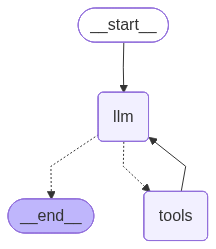

In [64]:
display(Image(app.get_graph(xray=True).draw_mermaid_png()))